In [1]:
from langchain_naver import ChatClovaX
import uuid, os, json, asyncio, requests
from typing import Annotated, List, TypedDict, Dict, Optional, Any
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_core.runnables import RunnableConfig
from prompt import *
from task1_funcs import *
from task1_tools import *
from task2_tools import *
from task5_tools import *  
from utils import *

load_dotenv(r'C:\Users\rladl\Desktop\Mirae_Agent\MIRAE_ASSET_AI-Festival\sasha\test\.env')

clova = ChatClovaX(
    api_key=os.getenv('NCP_CLOVASTUDIO_API_KEY'),
    model="HCX-005",
    temperature=0.2,
    max_tokens=None,
    timeout=None,
    # max_retries,
    # repeat_penalt,
    # repetition_penalty,
    # stop,
    # seed,
    # top_k,
    # top_p,
)

# Function Calling 호출 API
API_KEY = os.getenv('NCP_CLOVASTUDIO_API_KEY')
REQUEST_ID = f"req-{uuid.uuid4()}"

url = "https://clovastudio.stream.ntruss.com/testapp/v3/chat-completions/HCX-005"
headers = {

    "Authorization": f"Bearer {API_KEY}",
    "X-NCP-CLOVASTUDIO-REQUEST-ID": REQUEST_ID,
    "Content-Type": "application/json"
}

Error occurred during getting browser(s): random, but was suppressed with fallback.


In [2]:
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]  
    decision_task: Annotated[str, "Decision_task"]
    tools: Annotated[List, "Tools"]
    tools_response: Annotated[str, "Tools_Response"]

    # 디버깅용 Task1, Task2, Task3, Task4 응답 저장
    task1_response: Annotated[Optional[Dict], "Task2_Response"]
    task2_response: Annotated[Optional[Dict], "Task2_Response"]
    task3_response: Annotated[Optional[Dict], "Task2_Response"]
    task4_response: Annotated[Optional[str], "Task4_Response"]
    task5_response: Annotated[Optional[str], "Task5_Response"]

    answer: Annotated[str, "Final_Answer"]  
    
    # Task5 멀티턴 대응용 필드 (추가)
    session_id: Annotated[Optional[str], "Session_ID"]
    messages: Annotated[List[Dict[str, str]], "Messages"] 

# 메모리 저장소 초기화
memory = MemorySaver()

In [3]:
async def decision_task(state: ChatbotState) -> ChatbotState:
    """
    LLM이 어떤 Task를 골랐는지 설명을 섞어 출력해도
    'Task1'·'Task2'·'Task3'·'Task4' 형태로 정확히 추출해 state에 저장.
    """
    user_query = state["question"]

    # LLM에게 task 분류 요청
    prompt = TASK_ROUTER_PROMPT.format(question=user_query)
    messages = [("system", prompt)]

    llm_response = await clova.ainvoke(messages)
    raw_text = llm_response.content or ""

    # 1) 공백 제거 및 소문자 정규화
    normalized = re.sub(r"\s+", "", raw_text)

    # 2) 'task' + 숫자 패턴 추출
    m = re.search(r"task\s*([0-9]+)", normalized, re.IGNORECASE)

    # 3) 결과 결정
    decision = f"Task{m.group(1)}" if m else normalized

    # # Task5 진입 시 session_id 생성 + messages 초기화
    # if decision == "Task5":
    #     if not state.get("session_id"):
    #         state["session_id"] = str(uuid.uuid4())

    #     state["messages"] = [{"role": "user", "content": user_query}]

    # 결과 상태 업데이트
    state["decision_task"] = decision
    return state

In [4]:
async def task1_tools(state: ChatbotState):
    user_query = state["question"]

    data = {
    "model": "HCX-005",
    "messages": [
        {"role":"system","content": TOOLS_PROMPT},
        {"role":"user","content": user_query}
    ],
    "tools" : [{"type": "function", "function": s} for s in task1_functions],
    "tool_choice": "auto"
    }

    response = requests.post(url, headers=headers, json=data)
    result = response.json()

    tool_calls = result['result']['message']['toolCalls']

    for call in tool_calls:
        fn_name = call["function"]["name"]
        args    = call["function"]["arguments"]     # dict 또는 JSON 문자열
        if isinstance(args, str):
            args = json.loads(args)

        py_func = task1_py_funcs.get(fn_name)
        if py_func is None:
            raise ValueError(f"Unsupported function: {fn_name}")

        # 동기/비동기 모두 지원
        if asyncio.iscoroutinefunction(py_func):
            out = await py_func(**args)
        else:
            out = await asyncio.to_thread(py_func, **args)

    return ChatbotState(tools=result,
                        tools_response=out)


In [5]:
async def task2_tools(state: ChatbotState):
    user_query = state["question"]

    # 1. 모델 응답
    messages = [("system", TASK2_PROMPT),("human", user_query)]
    ai_msg = clova.invoke(messages)

    # 2. 응답 전처리
    llm_question_analysis = parse_llm_json(ai_msg.content)

    # 3. 최종 응답
    result = screen_stocks(llm_question_analysis)
    
    return ChatbotState(task2_response=result)


In [6]:
async def task3_tools(state: ChatbotState):
    user_query = state["question"]

    data = {
    "model": "HCX-005",
    "messages": [
        {"role":"user","content": user_query}
    ],
    "tools" : [{"type": "function", "function": s} for s in task1_functions],
    "tool_choice": "auto"
    }

    response = requests.post(url, headers=headers, json=data)
    result = response.json()

    return ChatbotState(tools=result)


In [7]:
async def task4_tools(state: ChatbotState):
    """
    Task4: 모호한 의미 해석 및 재질의 처리
    """
    user_query = state["question"]

    prompt = TASK4_FINAL_PROMPT.format(
        question=user_query
    )

    data = {
        "model": "HCX-005",
        "messages": [
            {"role": "system", "content": prompt},
            {"role": "user", "content": user_query}
        ]
    }

    response = requests.post(url, headers=headers, json=data)
    content = response.json()["result"]["message"]["content"]

    return ChatbotState(
        question=user_query,
        decision_task="Task4",
        task4_response=content,
        answer=content
    )

In [8]:
import asyncio
import json
import requests
from typing import Dict, Any
def convert_numpy_types(obj):
    """numpy 타입을 Python 기본 타입으로 변환"""
    if isinstance(obj, np.float64):
        return float(obj)
    elif isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj
import logging

async def task5_tools(state: ChatbotState):
    user_query = state["question"]
    
    data = {
        "model": "HCX-005",
        "messages": [
            {"role": "system", "content": TASK5_TOOLS_PROMPT.format(
                question=user_query,
                tool_result=""
            )},
            {"role": "user", "content": user_query}
        ],
        "tools": task5_functions,
        "tool_choice": "auto"
    }

    response = requests.post(url, headers=headers, json=data)

    try:
        result = response.json()
    except Exception as e:
        raise ValueError(f"[JSON 파싱 오류] {e}\n응답 원문: {response.text}")

    # ✅ 응답 구조 점검
    if not result or "result" not in result or result["result"] is None:
        raise ValueError(f"[API 응답 오류] 'result' 없음 또는 None\nresult: {result}")
    
    if "message" not in result["result"] or "toolCalls" not in result["result"]["message"]:
        raise ValueError(f"[API 응답 오류] 'message' 또는 'toolCalls' 없음\nresult: {result['result']}")

    tool_calls = result["result"]["message"]["toolCalls"]

    all_outputs = {}
    final_output = None

    for call in tool_calls:
        fn_name = call["function"]["name"]
        args = call["function"]["arguments"]
        if isinstance(args, str):
            args = json.loads(args)

        py_func = task5_py_funcs.get(fn_name)
        if py_func is None:
            raise ValueError(f"지원하지 않는 함수: {fn_name}")

        if asyncio.iscoroutinefunction(py_func):
            out = await py_func(**args)
        else:
            out = await asyncio.to_thread(py_func, **args)

        out = convert_numpy_types(out)
        all_outputs[fn_name] = out
        final_output = out

    return ChatbotState(
        tools=convert_numpy_types(result),
        tools_response=convert_numpy_types(final_output),
        all_tool_outputs=convert_numpy_types(all_outputs)
    )


In [9]:
async def agent_answer(state: ChatbotState):
    user_query = state["question"]
    tool = state['tools']
    decision_task = state['decision_task']
    task2_res = state['task2_response']
    task4_res = state.get('task4_response', '')  # Task4 응답 추가
    task5_res = state.get('task5_response', '')  # Task5 응답 추가

    if decision_task == 'Task1':
        prompt = ANSWER_PROMPT.format(question=user_query, 
                                      tool_result=tool)
        messages = [("system", prompt)]
        llm_resp = await clova.ainvoke(messages)
        answer = llm_resp.content.strip()

    elif decision_task == 'Task2':
        prompt = TASK2_FINAL_PROMPT.format(question=user_query,
                                           tool_result=task2_res)
        messages = [("system", prompt)]
        llm_resp = await clova.ainvoke(messages)
        answer = llm_resp.content.strip()

    elif decision_task == 'Task3':
        prompt = ANSWER_PROMPT.format(question=user_query, 
                                      tool_result=tool)
        messages = [("system", prompt)]
        llm_resp = await clova.ainvoke(messages)
        answer = llm_resp.content.strip()

    elif decision_task == 'Task4':
        prompt = TASK4_FINAL_PROMPT.format(question=user_query,
                                           tool_result=task4_res)
        messages = [("system", prompt)]
        llm_resp = await clova.ainvoke(messages)
        answer = llm_resp.content.strip()


    elif decision_task == 'Task5':
        prompt = TASK5_FINAL_PROMPT.format(question=user_query,
                                            tool_result=task5_res)
        messages = [("system", prompt)]
        llm_resp = await clova.ainvoke(messages)
        answer = llm_resp.content.strip()

    else:
        answer = "죄송합니다. 질문을 이해하지 못했습니다. 다시 한번 구체적으로 질문해 주세요."

    return ChatbotState(answer=answer,
                        messages=[("user", user_query), ("assistant", answer)])

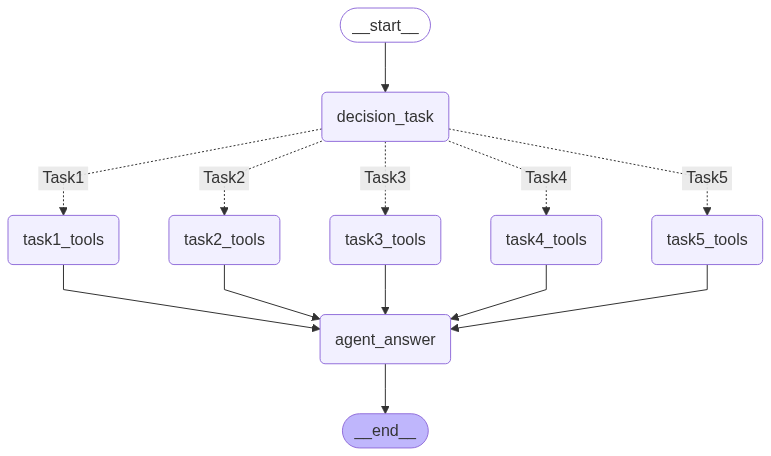

In [10]:
def route_tools(state: ChatbotState):
    return state["decision_task"]

# StateGraph 구성
builder = StateGraph(ChatbotState)

builder.add_node("decision_task", decision_task)

builder.add_node("task1_tools", task1_tools)
builder.add_node("task2_tools", task2_tools)
builder.add_node("task3_tools", task3_tools)
builder.add_node("task4_tools", task4_tools) # Task4 노드 추가
builder.add_node("task5_tools", task5_tools) # Task4 노드 추가
builder.add_node("agent_answer", agent_answer)

builder.add_edge(START, "decision_task")

builder.add_conditional_edges(
    "decision_task",
    route_tools,
    {
        "Task1": "task1_tools",
        "Task2": "task2_tools",
        "Task3": "task3_tools",
        "Task4": "task4_tools",
        "Task5": "task5_tools"
    }
)
builder.add_edge("task1_tools", "agent_answer")
builder.add_edge("task2_tools", "agent_answer")
builder.add_edge("task3_tools", "agent_answer")
builder.add_edge("task4_tools", "agent_answer")  # Task4 엣지 추가
builder.add_edge("task5_tools", "agent_answer")  # Task5 엣지 추가
builder.add_edge("agent_answer", END)

builder.compile(checkpointer=memory)

In [11]:
# ============================================================================
# 1. Task 테스트 실행
# ============================================================================

async def test_task(test_cases: List[str]):
    """Task 기능을 테스트하는 함수"""
    config = RunnableConfig(configurable={"thread_id": 1}) # 실행 환경 설정
    graph = builder.compile(checkpointer=memory) 

    
    for question in test_cases:
        print(f"\n{'='*50}")
        print(f"질문: {question}")
        print('='*50)
        
        # Chatstate 초기화 
        initial_state = { 
            "question": question,
            "decision_task": "",
            "tools": [],
            "tools_response": "",
            "task2_response": {},
            "task4_response": "",
            "answer": "", # 최종 답변
            "messages": [], # 멀티턴 대화를 위한 message 히스토리
        }
        
        events = [] # Agent 실행과정에서의 중간 이벤트 저장
        async for event in graph.astream(initial_state, config=config):
            events.append(event)
            
        # 결과 출력
        for event in events:
            if "decision_task" in event:
                print(f"🔍 분류: {event['decision_task']['decision_task']}")
            
            # 2. taskX_tools 단계에서 생성된 raw answer 출력
            elif any(k.startswith("task") and "answer" in v for k, v in event.items()):
                for k, v in event.items():
                    if k.startswith("task") and "answer" in v:
                        print(f"task단계 raw 결과 ({k}):\n{v['answer']}")

            elif "agent_answer" in event and "answer" in event["agent_answer"]:
                print(f"💬 답변:\n{event['agent_answer']['answer']}")


# 실행
# await test_task()

In [12]:
# =========================
# Task 1 예시
# =========================

test_cases = [
# Task 1 예시
"삼성전자 어제 종가는?",
"2024년 1월 15일 거래량 상위 5개 종목", 
"현대차 지난주 상승률",
]

# await test_task(test_cases)

In [13]:
# =========================
# Task 2 예시
# =========================

test_cases = [  
"PER 10 이하이면서 거래량 평균 대비 200% 이상인 종목",
"시가총액 1조 이상 KOSPI 종목 중 전일 대비 3% 이상 상승",
"배당률 4% 이상인 금융주",
]

# await test_task(test_cases)

In [14]:
# =========================
# Task 4 예시
# =========================

test_cases = [  
"최근 많이 오른 주식",
"요즘 핫한 테마주", 
"고점 대비 가장 많이 떨어진 종목",
]

In [15]:
# =========================
# Task 5 예시
# =========================

# 5.1 기본테스트
test_cases_5_1 = [ 
# "삼성전자 지금 사도 될까?",
"카카오 현재 밸류에이션 어떻게 생각해?"
]

await test_task(test_cases_5_1)


질문: 카카오 현재 밸류에이션 어떻게 생각해?


ValueError: [API 응답 오류] 'result' 없음 또는 None
result: {'status': {'code': '40000', 'message': 'Bad Request'}, 'result': None}

In [ ]:
test_cases_5_2 =[
# "삼성전자 작년 12월 15일 종가 기준 구매했을때, 2020년부터 2022년까지 삼성전자의 연도별 PER과 2021년 12월 15일의 종가를 최근 3년간 평균 PER 기준으로 저평가인지 판단해줘.",
"AK홀딩스 12월 15일에 150달러에 매수했을 때의 밸류에이션(PER, PBR)과 이후 수익률 기준으로, 해당 매수 판단이 적절했는지 분석해줘.",
# "테슬라의 최근 4개 분기 실적과 현재 PER, 성장률을 기준으로 투자 매력이 있는지 분석해줘.",
# "카카오의 최근 3개 분기 실적과 현재 주가 기준 PER, PBR, EV/EBITDA 지표를 바탕으로 고평가인지 저평가인지 분석해줘.",
# "한화솔루션을 작년 평균 종가(또는 특정일 종가)에 매수했을 때 현재까지의 수익률과 당기 실적 변화 기준으로 매수 판단이 적절했는지 분석해줘."
]

await test_task(test_cases_5_2)


질문: AK홀딩스 12월 15일에 150달러에 매수했을 때의 밸류에이션(PER, PBR)과 이후 수익률 기준으로, 해당 매수 판단이 적절했는지 분석해줘.


ValueError: [API 응답 오류] 'result' 없음 또는 None
result: {'status': {'code': '40000', 'message': 'Bad Request'}, 'result': None}